Variant of the Upper confidence bound (UCB) algorithm
-----------------------------------------------------
To online-learn returns of a multi-arm bandit and sample from it at the same time.

*I don't know what I am doing. I just made this up.* Real UCB algorithms 
sample the best known arm, i.e. the one with the largest upper bound on the
expected return. Over time, as the arms are sampled more often the estimates
of the returns get better and better and the 'boni' added up to get the upper 
bounds keep shrinking. 

I sample in proportion to the upper bounds. What I really want is to do some 
exploring and after a while transition to exploiting, i.e. sample in proportion 
to the expected returns.

Ref for regular UCB: https://arxiv.org/pdf/1402.6028.pdf

DeepMind video on UCB https://youtu.be/eM6IBYVqXEA?t=2896

Some guy writing about the tree search used in AlphaZero. https://web.stanford.edu/~surag/posts/alphazero.html Uses a UCB algo.

Compute graphics paper by Vevoda et al. (2018) "Bayesian online regression for adaptive direct illumination sampling". https://cgg.mff.cuni.cz/~jaroslav/papers/2018-bayesianlighting/2018-vevoda-bayesianlighting-paper.pdf  They don't have any exploration at all apparently. Instead they start from good priors. Then sample according to a linear combination of mean and variance. Use Bayesian learning to learn the true mean and variances from the sampled returns. Much like so called Bayesian Bandit algorithms.

In [1]:
import numpy as np
import collections
from runstats import Statistics
%matplotlib notebook
from matplotlib import pyplot

In [2]:
true_returns = np.asarray([0.1, 1., 2., 10., 20.])
true_stddev =np.asarray([0.05, 4., 0.1, 2., 2.])
n_arms = len(true_returns)

In [54]:
class UCBSampler(object):
    def __init__(self, n):
        self.stats = [ Statistics() for _ in range(n)]
        self.counts = np.zeros(n, np.int32)
        self.arm_probs = np.ones(n, np.float) / n
        self.n = n
        self.t = 1
        self.confidence_multiplier = 1
        self.last_u = None
    def observe_play(self, i, x):
        self.stats[i].push(x)
        self.counts[i] += 1
    def update(self):
        w = np.asarray([ s.mean() for s in self.stats ])
        stddev = np.asarray([ (s.stddev() if n>1 else 0.) for s,n in zip(self.stats,self.counts) ])
        self.last_u = u = stddev*np.sqrt(np.log(self.t)/(self.counts))
        w += self.confidence_multiplier*u
        w = np.abs(w)
        w[self.counts==0] = 1.e6
        self.arm_probs = w / np.sum(w)
        self.t += 1
    def get_next_to_play(self):
        return np.random.choice(self.n, p =self.arm_probs)

In [55]:
def run(sampler, m):
    for _ in range(m):
        i = sampler.get_next_to_play()
        val = np.random.normal(loc=true_returns[i], scale=true_stddev[i])
        sampler.observe_play(i, val)
    sampler.update()

In [72]:
np.random.seed(89890)
s = UCBSampler(n_arms)
probability_history = []
for iter in range(1000):
    s.update()
    probability_history.append(s.arm_probs.copy())
    run(s, 10)
probability_history = np.asarray(probability_history)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


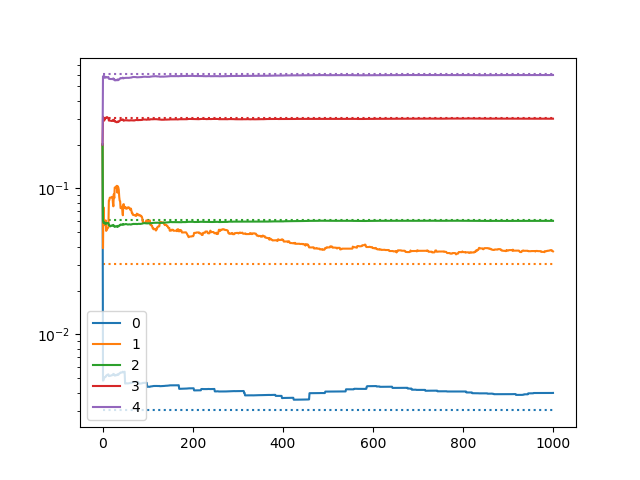

In [73]:
normalized_returns = true_returns / np.sum(true_returns)
fig, ax = pyplot.subplots(1,1)
T = np.arange(len(probability_history))
for i in range(n_arms):
    plt, = ax.plot(T, probability_history.T[i], label=i)
    ax.hlines(normalized_returns[i], 0, T.shape[0], linestyles=':', color=plt.get_color())
ax.set(yscale='log')
ax.legend()
pyplot.show()

In [51]:
for prob, stat in zip(s.arm_probs, s.stats):
    print ("val = {} +/- {}, sampling prob = {}".format(stat.mean(), stat.stddev(), prob))

val = 0.09851965208277938 +/- 0.0558328127386092, sampling prob = 0.003058989960572261
val = 0.8167411550640373 +/- 3.9675429984665884, sampling prob = 0.026839773080746386
val = 1.9979962168601837 +/- 0.10119664641208644, sampling prob = 0.060592773201220994
val = 9.973604104094209 +/- 2.0200075296930518, sampling prob = 0.3026066889693111
val = 20.016106643233982 +/- 1.9984881129571839, sampling prob = 0.6069017747881492
